In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import csv
import matplotlib.pyplot as plt

from collections import defaultdict
import copy

In [2]:
# Prepare data
data_dir = "./ml-1m/"
# 1. User Data
with open(data_dir + "users.dat", "r") as user_info_file :
    lines = user_info_file.readlines()
    n_users = len(lines)
    user_characteristics = {}
    userID = {}
    age_group = {1: 0, 18: 1, 25: 2, 35: 3, 45: 4, 50: 5, 56: 6}

    for i, line in enumerate(lines) :
        user_info = line.strip().split("::")
        user_id = int(user_info[0])
        userID[user_id] = i # real user_id -> index
        user_sex = 0 if user_info[1] == "M" else 1
        user_age_group = [0 for _ in range(len(age_group))]
        user_age_group[age_group[int(user_info[2])]] = 1
        user_occupation_group = [0 for _ in range(21)]
        user_occupation_group[int(user_info[3])] = 1
        user_zip_code = [0 for _ in range(10)]
        user_zip_code[int(user_info[4][0])] = 1

        user_characteristics[i] = [user_id, user_sex] + user_age_group + user_occupation_group + user_zip_code

user_data = pd.DataFrame.from_dict(user_characteristics, orient="index", columns=["user_id", "user_sex"] + [f"age_group{i}" for i in range(7)] + [f"user_occupation{i}" for i in range(21)] + [f"user_zip_code{i}" for i in range(10)])
user_data

,user_id,user_sex,age_group0,age_group1,age_group2,age_group3,age_group4,age_group5,age_group6,user_occupation0,...,user_zip_code0,user_zip_code1,user_zip_code2,user_zip_code3,user_zip_code4,user_zip_code5,user_zip_code6,user_zip_code7,user_zip_code8,user_zip_code9
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,3,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,5,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,6036,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6036,6037,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6037,6038,1,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
6038,6039,1,0,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0


In [3]:
# 2. Item Data
with open(data_dir + "movies.dat", "r", encoding="ISO-8859-1") as item_info_file :
    lines = item_info_file.readlines()
    n_items = len(lines)
    item_characteristics = {}
    itemID = {}
    genres = {"Action":0, "Adventure":1, "Animation":2, "Children's":3, "Comedy":4, "Crime":5, "Documentary":6, "Drama":7,                     "Fantasy":8, "Film-Noir":9, "Horror":10, "Musical":11, "Mystery":12, "Romance":13, "Sci-Fi":14, "Thriller":15,                   "War":16, "Western":17}
    for i, line in enumerate(lines) :
        item_info = line.strip().split("::")
        item_id = int(item_info[0])
        itemID[item_id] = i
        item_name = " ".join(item_info[1].split(" ")[:-1])
        item_genres = [0 for _ in range(len(genres))]
        for item_genre in item_info[2].split("|") :
            item_genres[genres[item_genre]] = 1
        
        item_characteristics[i] = [item_id, item_name] + item_genres

item_data = pd.DataFrame.from_dict(item_characteristics, orient="index", columns=["item_id", "item_name"] + list(genres.keys()))
item_data     

,item_id,item_name,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,Meet the Parents,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3879,3949,Requiem for a Dream,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3880,3950,Tigerland,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3881,3951,Two Family House,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [4]:
# 3. Rating Data
with open(data_dir + "ratings.dat") as rating_info_file :
    lines = rating_info_file.readlines()
    rating_info = []
    user_rated = defaultdict(lambda: [])
    for line in lines :
        user_id, item_id, rating = list(map(int, line.strip().split("::")[:-1]))
        rating_info.append([user_id, item_id, rating])
        user_rated[user_id].append([item_id, rating])

rating_data = pd.DataFrame(rating_info, columns=["user_id", "item_id", "rating"])
rating_data

,user_id,item_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1000204,6040,1091,1
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


In [5]:
# Get User Feature
# 1. Watched Video - one-hot Encoding
# 2. Like/Dislike Video - one-hot encoding(no rating/3 -> 0, 1/2 -> dislike, 4/5 -> like)
watched_items = [[0 for _ in range(n_items)] for _ in range(n_users)]
like_items = [[0 for _ in range(n_items)] for _ in range(n_users)]
dislike_items = [[0 for _ in range(n_items)] for _ in range(n_users)]
pred_items = [[] for _ in range(n_users)]
user_ids = list(user_data["user_id"].values)

for i in range(n_users) :
    user_id = user_ids[i]
    user_watched_items, user_ratings = zip(*user_rated[user_id])
    for watched_item, rating in zip(user_watched_items, user_ratings) :
        j = itemID[watched_item]
        watched_items[i][j] = 1
        if rating >= 4 :
            like_items[i][j] = 1
        elif rating <= 2 :
            dislike_items[i][j] = 1
    pred_items[i].append(j)

watched_items = np.array(watched_items)
like_items = np.array(like_items)
dislike_items = np.array(dislike_items)
pred_items = np.array(pred_items)

user_feature = np.concatenate((watched_items, like_items, dislike_items), axis=-1)
user_feature.shape

(6040, 11649)

In [6]:
# 3. User's Profile
user_sex = np.expand_dims(user_data["user_sex"].values, 0)
user_feature = np.concatenate((user_feature, user_sex.T), axis=1)

user_age_group = user_data[[f"age_group{i}" for i in range(7)]].values
user_feature = np.concatenate((user_feature, user_age_group), axis=1)
user_feature.shape

(6040, 11657)

In [7]:
user_occupation_group = user_data[[f"user_occupation{i}" for i in range(21)]].values
user_zip_code = user_data[[f"user_zip_code{i}" for i in range(10)]].values

user_feature = np.concatenate((user_feature, user_occupation_group, user_zip_code), axis=1)
user_feature.shape

(6040, 11688)

In [8]:
# Deep Learning Process
class MLP(nn.Module) :

    def __init__(self, input_dim, output_dim, hidden_dim) :
        super(MLP, self).__init__()
        input_dims = [input_dim] + hidden_dim
        output_dims = hidden_dim + [output_dim]

        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        for in_dim, out_dim in zip(input_dims, output_dims) :
            self.layers.append(nn.Linear(in_dim, out_dim).double())
            self.activations.append(nn.ReLU())

    def forward(self, x) :

        for l, activ in zip(self.layers, self.activations) :
            x = l(x)
            x = activ(x)
        return x

In [9]:
# Training a Model

model = MLP(input_dim = user_feature.shape[1], output_dim=n_items, hidden_dim=[1024, 512, 256, 128])
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100
user_feature = torch.tensor(user_feature, dtype=torch.float64)
pred_items = torch.from_numpy(pred_items).long().squeeze().detach()
for epoch in range(epochs) :

    policy = model(copy.deepcopy(user_feature))
    loss_ftn = nn.CrossEntropyLoss()
    loss = loss_ftn(policy, pred_items)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(epoch+1, loss.item())

1 8.263243560386572
2 8.240887761567732
3 8.17212632856783
4 8.00771833426072
5 7.696484672380539
6 7.328144172396007
7 7.120759456578892
8 6.7435390487682385
9 6.62678720978417
10 6.3490927484211515
11 5.979235344983357
12 5.892940051747307
13 5.693758273788255
14 5.588955960902947
15 5.471044708509637
16 5.293670898597385
17 5.170605292706603
18 5.096519031250685
19 4.99212113857555
20 4.935121179964489
21 4.891529101139252
22 4.811683641286199
23 4.734349807749647
24 4.685295974412471
25 4.638913183468096
26 4.580056203675284
27 4.534555306901058
28 4.498814811929361
29 4.465874101592976
30 4.4285019265412275
31 4.382648123491191
32 4.337788398903644
33 4.298712662718081
34 4.261131740493154
35 4.222697399105988
36 4.182345095550113
37 4.141262213959558
38 4.102051225322695
39 4.063814090735481
40 4.025515678369857
41 3.98700186103786
42 3.9464605972796756
43 3.905069430517577
44 3.8637093612395566
45 3.821463621028489
46 3.7768967159233875
47 3.7308547379094
48 3.684914085084586
49

In [10]:
final_policy = model(copy.deepcopy(user_feature)).detach().numpy()
top_k_recommendations = np.argsort(final_policy, axis=1)
print(top_k_recommendations.shape)

(6040, 3883)


0.055067926408701465
0.08151763366577114
0.1014798241678051


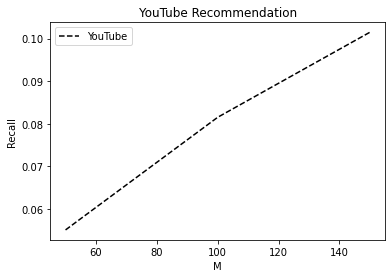

In [14]:
# Metric : Top K Recommendations

# reacall@ performance
M = [50, 100, 150, 200, 250, 300]
accuracy = []
for m in M :
    all_cnt = 0
    for i in range(n_users):
        top_k_recommendation = set(top_k_recommendations[i][-m:])
        like_item = set(filter(lambda x : like_items[i,x]!= 0, [i for i in range(n_items)]))
        cnt_hit = len(top_k_recommendation&like_item)
        if len(like_item) != 0 :
            all_cnt += cnt_hit / len(like_item)
    accuracy.append(all_cnt / n_users)
    print(accuracy[-1])
plt.plot(M, accuracy, linestyle = "dashed", label = "YouTube", color = "black")
plt.xlabel("M")
plt.ylabel("Recall")
plt.title("YouTube Recommendation")
plt.legend()
plt.savefig("./data/youtube_recommendation.png")

df = pd.DataFrame(accuracy, columns=["accuracy"])
df.to_csv("./data/youtube_recommendation.csv") 